# Apple Leaf and Fruit Diseases Classification Using Inception V3


Dataset credits: https://github.com/hsaleem1/NZDLPlantDisease-v1

Mount Google Drive

In [ ]:
#Mount google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path ="/content/drive/MyDrive/Classroom/NewNZdataset"

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model

### Set all the Constants

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 299  #---“input shape has to be `(224, 224, 3)” → INCEPTIONV3
CHANNELS=3
epochs =100
classes =7

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15706 files belonging to 7 classes.


In [ ]:
#Print class names
class_names = dataset.class_names

class_names

['Black rot',
 'Black spot',
 'European Canker',
 'Healthy Fruit',
 'Healthy Leaf',
 'Leaf spot (scab)',
 'Mosaic virus ']

EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
#Total number of images ≈ Number of batches × Batch size
len(dataset)

246

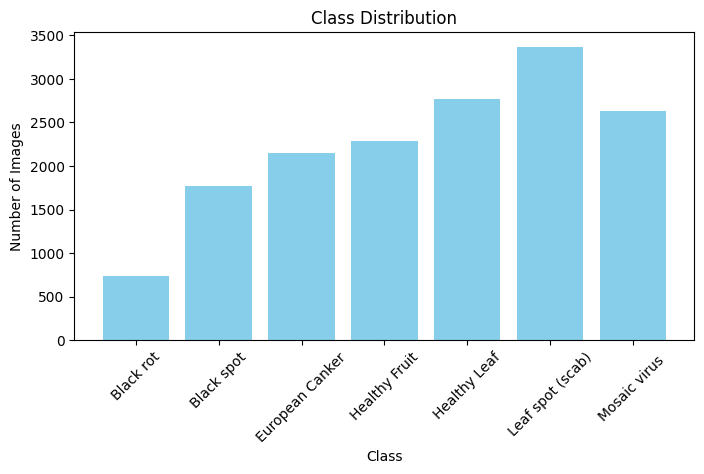

In [ ]:
# Calculate the number of images per class
class_counts = dict.fromkeys(class_names, 0)

for images, labels in dataset:
    for label in labels:
        label = int(label.numpy())  # Convert to int if necessary
        class_counts[class_names[label]] += 1

# Plotting the class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Count the Element in Each Class

In [ ]:
import tensorflow as tf
from collections import defaultdict

class_counts = defaultdict(int)

# Iterate through the dataset to count occurrences of each class
for batch in dataset:
    # Extract labels from the batch
    labels = batch[1]

    # Count occurrences of each label in this batch
    for label in labels:
        class_counts[label.numpy()] += 1

# Display the counts for each class with class names
print("Class counts:")
for class_index, count in class_counts.items():
    class_name = class_names[class_index]
    print(f"{class_name}: {count} images")

Class counts:
Leaf spot (scab): 3368 images
Healthy Leaf: 2765 images
Mosaic virus : 2636 images
Black spot: 1766 images
Healthy Fruit: 2282 images
European Canker: 2147 images
Black rot: 742 images


# Defining Class Weights

There are many more observations of the Leaf spot class, and so this will have a larger impact on the overall value of the loss function than observations belonging to the other classes. the weight is going to be used for training the models

In [ ]:
# Example class counts (use your actual counts)
class_counts = {
    "Healthy Leaf": 2765,
    "Healthy Fruit": 2282,
    "Black spot": 1766,
    "European Canker": 2147,
    "Mosaic virus": 2636,
    "Leaf spot (scab)": 3368,
    "Black rot": 742,
}

# Total number of samples and unique classes
total_samples = sum(class_counts.values())
num_classes = len(class_counts)

# Calculate class weights
class_weights = {}
for i, (class_name, count) in enumerate(class_counts.items()):
    weight = total_samples / (num_classes * count)
    class_weights[i] = weight

In [ ]:
#Check the shape of the first batch
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [ ]:
for image_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[[170.         208.          69.        ]
   [173.13713    208.          89.391304  ]
   [125.96489    152.27927     71.943146  ]
   ...
   [250.43811    253.07858    202.23575   ]
   [253.43143    255.         209.72571   ]
   [255.         255.         216.        ]]

  [[155.09866    193.09866     55.667225  ]
   [167.46223    202.32512     84.05478   ]
   [146.43619    172.75056     91.409836  ]
   ...
   [249.81253    252.453      199.03699   ]
   [249.95595    251.86287    204.00494   ]
   [250.29431    251.86287    206.58862   ]]

  [[148.43813    185.79765     52.        ]
   [161.33025    196.05496     79.0708    ]
   [158.42873    185.1533     101.30532   ]
   ...
   [252.66287    254.02242    197.28644   ]
   [252.8428     253.56187    201.84128   ]
   [252.8428     253.56187    205.9214    ]]

  ...

  [[ 76.92142    103.92142     52.921417  ]
   [ 76.19876    103.19876     52.19877   ]
   [ 77.28094    104.28094     53.280937  ]
   ...
   [209.41388    230.87988    127.3

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

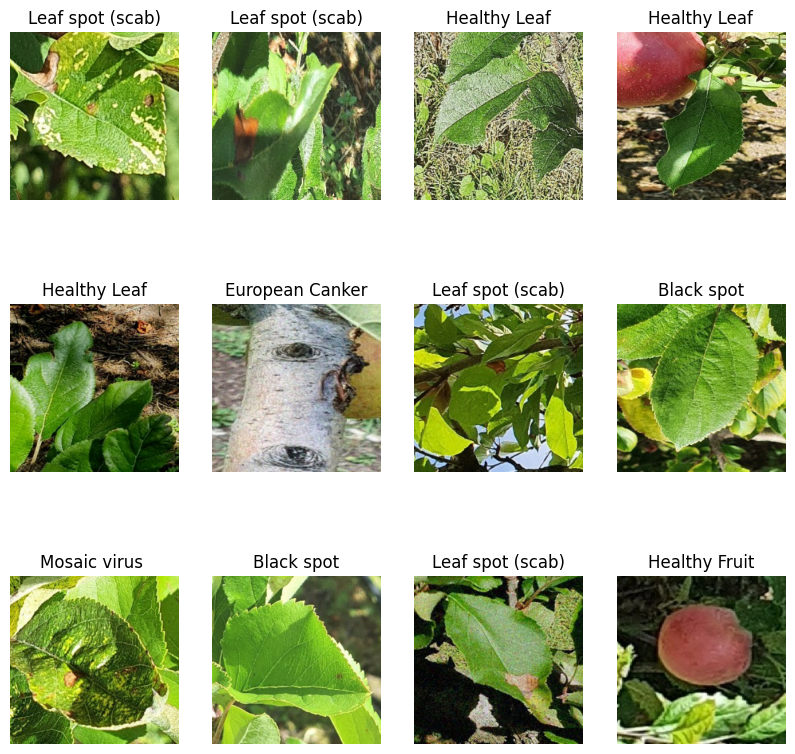

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

172

In [ ]:
len(val_ds)

49

In [ ]:
len(test_ds)

25

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Creating a Layer for Normalization
Before we feed our images to network,  to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 255).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


In [ ]:
#normalization
rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Rescaling(1./255),
])

## Building the Model

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for normalization

 #  Training from Scratch  

In [ ]:
from keras.models import Model
from keras.layers import Concatenate
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization

Convolutional layer

In [ ]:
def conv_with_Batch_Normalisation(prev_layer , nbr_kernels , filter_Size , strides =(1,1) , padding = 'same'):
    x = Conv2D(filters=nbr_kernels, kernel_size = filter_Size, strides=strides , padding=padding)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    return x

In [ ]:
def StemBlock(prev_layer):
    x = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 32, filter_Size=(3,3) , strides=(2,2))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 32, filter_Size=(3,3))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 64, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 80, filter_Size=(1,1))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 192, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)

    return x


Inception Blocks

In [ ]:
def InceptionBlock_A(prev_layer  , nbr_kernels):

    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))

    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=48, filter_Size=(1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels=64, filter_Size=(3,3)) # may be 3*3

    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = nbr_kernels, filter_Size = (1,1))

    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=64, filter_Size=(1,1))

    output = Concatenate(axis=3)([branch1, branch2, branch3, branch4])

    return output

def InceptionBlock_B(prev_layer , nbr_kernels):

    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))

    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 192, filter_Size = (7,1))

    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding ='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))

    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))

    output = Concatenate(axis=3)([branch1, branch2, branch3, branch4])

    return output

def InceptionBlock_C(prev_layer):

    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 448, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,3))
    branch1_1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (1,3))
    branch1_2 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,1))
    branch1 = Concatenate(axis=3)([branch1_1, branch1_2])

    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size = (1,1))
    branch2_1 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (1,3))
    branch2_2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (3,1))
    branch2 = Concatenate(axis=3)([branch2_1, branch2_2])

    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same')(prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))

    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 320, filter_Size = (1,1))

    output = Concatenate(axis=3)([branch1, branch2, branch3, branch4])

    return output

Reduction Blocks

In [ ]:
def ReductionBlock_A(prev_layer):

    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3) , strides=(2,2) ) #, padding='valid'

    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size=(3,3) , strides=(2,2) )

    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) , padding='same')(prev_layer)

    output = Concatenate(axis=3)([branch1, branch2, branch3])

    return output



def ReductionBlock_B(prev_layer):

    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (3,3) , strides=(2,2) , padding = 'valid')

    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1) )
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 320, filter_Size = (3,3) , strides=(2,2) , padding='valid' )

    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) )(prev_layer)

    output = Concatenate(axis=3)([branch1, branch2, branch3])

    return output

Auxiliary Classifier

In [ ]:
def auxiliary_classifier(prev_Layer):
    x = AveragePooling2D(pool_size=(5,5) , strides=(3,3)) (prev_Layer)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 128, filter_Size = (1,1))
    x = Flatten()(x)
    x = Dense(units = 768, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units = 1000, activation='softmax') (x)
    return x

The Inception model

In [ ]:
def inceptionV3():

    input_layer = Input(shape=(299 , 299 , 3))
    x = rescale(input_layer)

    x = StemBlock(x)

    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 32)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)

    x = ReductionBlock_A(prev_layer = x )

    x = InceptionBlock_B(prev_layer = x  , nbr_kernels = 128)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 192)

    Aux = auxiliary_classifier(prev_Layer = x)

    x = ReductionBlock_B(prev_layer = x)

    x = InceptionBlock_C(prev_layer = x)
    x = InceptionBlock_C(prev_layer = x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(units=2048, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units=classes, activation='softmax') (x)

    model = Model(inputs = input_layer , outputs = x , name = 'Inception-V3')

    return model

In [ ]:
# Instantiate the function
model = inceptionV3()

# Defining Callbacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),  # Factor to reduce learning rate
    patience=5,
    verbose=1
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs to wait before stopping
    verbose=1,
    restore_best_weights=True
)

Defining the Optimizer

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=epochs,
    class_weight = class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
172/172 - 204s - loss: 1.3656 - accuracy: 0.5211 - val_loss: 2.6964 - val_accuracy: 0.3409 - lr: 0.0010 - 204s/epoch - 1s/step
Epoch 2/100
172/172 - 79s - loss: 0.8167 - accuracy: 0.6688 - val_loss: 2.3934 - val_accuracy: 0.4892 - lr: 0.0010 - 79s/epoch - 459ms/step
Epoch 3/100
172/172 - 79s - loss: 0.6389 - accuracy: 0.7409 - val_loss: 1.0456 - val_accuracy: 0.6511 - lr: 0.0010 - 79s/epoch - 462ms/step
Epoch 4/100
172/172 - 80s - loss: 0.4689 - accuracy: 0.8182 - val_loss: 1.6008 - val_accuracy: 0.6607 - lr: 0.0010 - 80s/epoch - 463ms/step
Epoch 5/100
172/172 - 80s - loss: 0.3749 - accuracy: 0.8603 - val_loss: 0.4918 - val_accuracy: 0.8249 - lr: 0.0010 - 80s/epoch - 464ms/step
Epoch 6/100
172/172 - 80s - loss: 0.3009 - accuracy: 0.8885 - val_loss: 0.3636 - val_accuracy: 0.8709 - lr: 0.0010 - 80s/epoch - 465ms/step
Epoch 7/100
172/172 - 80s - loss: 0.3163 - accuracy: 0.8889 - val_loss: 3.5071 - val_accuracy: 0.4298 - lr: 0.0010 - 80s/epoch - 464ms/step
Epoch 8/100
172/172 -

Evaluate the model

In [ ]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 26s 257ms/step - loss: 0.0456 - accuracy: 0.9814


Make Prediction on a random image

first image to predict
actual label: Black spot
2/2 [==============================] - 6s 23ms/step
predicted label: Black spot


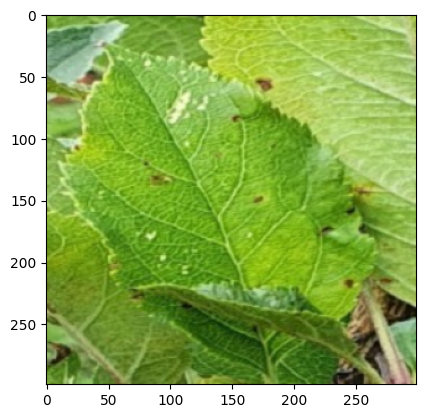

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Plotting training and validation accuracy, loss and learning rate

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

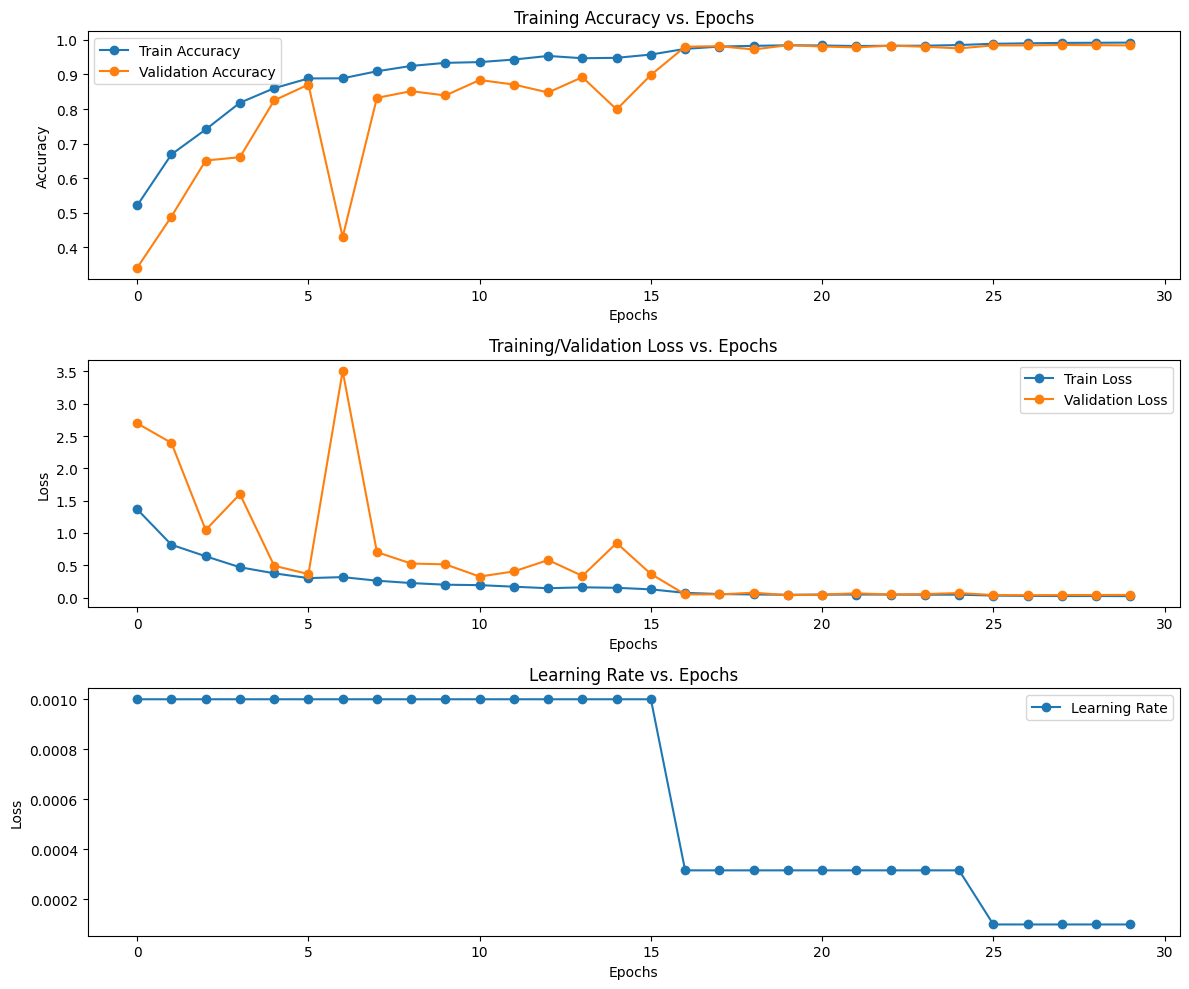

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Confusion Matrix

2/2 [==============================] - 0s 62ms/step


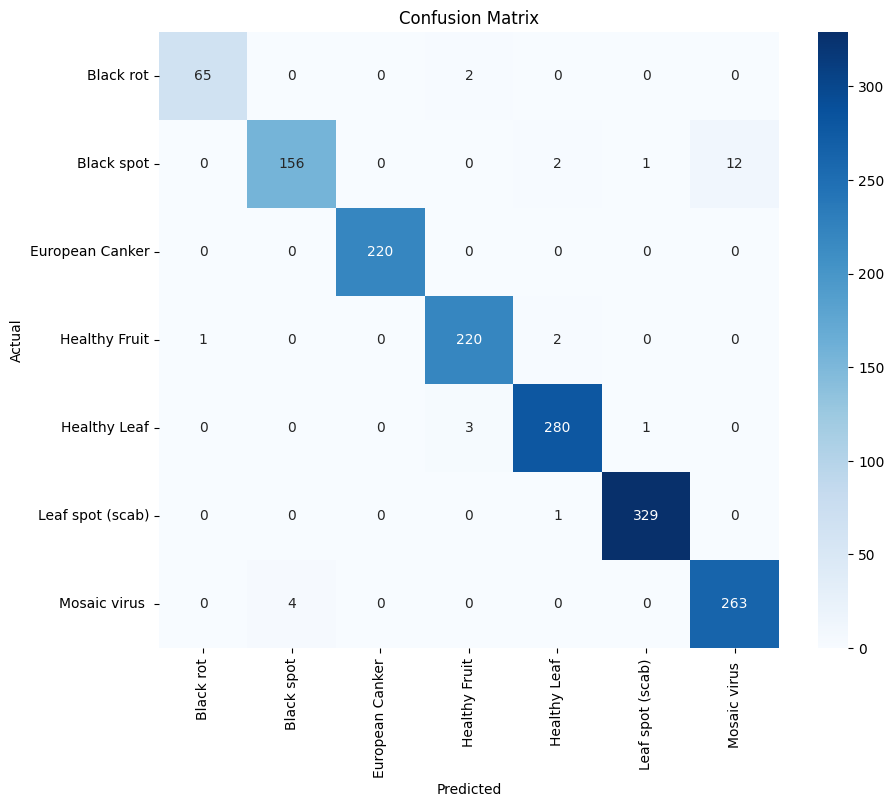

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes

# Confusion Matrix with class names
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Classification Report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.98      0.97      0.98        67
      Black spot       0.97      0.91      0.94       171
 European Canker       1.00      1.00      1.00       220
   Healthy Fruit       0.98      0.99      0.98       223
    Healthy Leaf       0.98      0.99      0.98       284
Leaf spot (scab)       0.99      1.00      1.00       330
   Mosaic virus        0.96      0.99      0.97       267

        accuracy                           0.98      1562
       macro avg       0.98      0.98      0.98      1562
    weighted avg       0.98      0.98      0.98      1562



ROC AUC

2/2 [==============================] - 0s 62ms/step


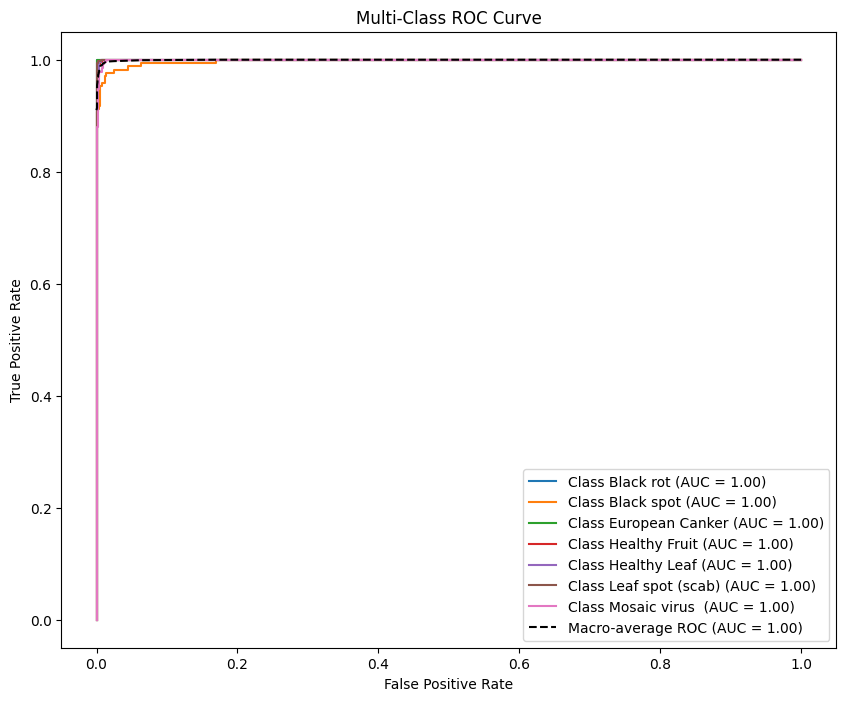

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions (probabilities)
    y_pred_probs.extend(predictions)  # Collect predicted probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)  # Ensure true labels are arrays
y_pred_probs = np.array(y_pred_probs)  # Ensure predicted probabilities are arrays

# Binarize the true labels to get a one-hot encoded representation
y_true_bin = label_binarize(y_true, classes=list(range(20)))

# Initialize ROC and AUC data
fpr = dict()  # False positive rates
tpr = dict()  # True positive rates
roc_auc = dict()  # AUC for each class

# Compute ROC and AUC for each class
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # ROC data for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # AUC for each class

# Compute macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)

# Compute mean true positive rates
for i in range(classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= classes  # Normalize by the number of classes
macro_auc = auc(all_fpr, mean_tpr)  # Macro-average AUC

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')  # Label with class names and AUC

# Plot the macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='k', linestyle='--', label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Transfer Learning

In [ ]:
from keras.applications import InceptionV3
from keras.layers import Input, Rescaling

input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # Adjust to your desired input shape
x = rescale(input)


In [ ]:
# Initialize the InceptionV3 model without 'input_tensor'
inception = InceptionV3(input_tensor=x, weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Freeze the layers of InceptionV3
for layer in inception.layers:
  layer.trainable =False


In [ ]:
x = GlobalAveragePooling2D()(inception.output)
prediction = Dense(classes, activation ='softmax')(x)
#create a model object
model_tl =Model(inputs =inception.input, outputs =prediction)
#View the structure of the model
model_tl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                               

In [ ]:
#Define Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),  # Factor to reduce learning rate
    patience=5,
    verbose=1
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs to wait before stopping
    verbose=1,
    restore_best_weights=True
)

In [ ]:
#Define the optimizer
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model_tl.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model_tl.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=epochs,
    class_weight = class_weights,
    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
172/172 - 83s - loss: 0.9109 - accuracy: 0.6453 - val_loss: 0.6368 - val_accuracy: 0.7494 - lr: 0.0010 - 83s/epoch - 485ms/step
Epoch 2/100
172/172 - 19s - loss: 0.5200 - accuracy: 0.8015 - val_loss: 0.4567 - val_accuracy: 0.8390 - lr: 0.0010 - 19s/epoch - 112ms/step
Epoch 3/100
172/172 - 19s - loss: 0.4247 - accuracy: 0.8397 - val_loss: 0.4072 - val_accuracy: 0.8508 - lr: 0.0010 - 19s/epoch - 111ms/step
Epoch 4/100
172/172 - 19s - loss: 0.3726 - accuracy: 0.8616 - val_loss: 0.3619 - val_accuracy: 0.8763 - lr: 0.0010 - 19s/epoch - 111ms/step
Epoch 5/100
172/172 - 19s - loss: 0.3320 - accuracy: 0.8795 - val_loss: 0.3314 - val_accuracy: 0.8925 - lr: 0.0010 - 19s/epoch - 111ms/step
Epoch 6/100
172/172 - 19s - loss: 0.3021 - accuracy: 0.8943 - val_loss: 0.3175 - val_accuracy: 0.8865 - lr: 0.0010 - 19s/epoch - 111ms/step
Epoch 7/100
172/172 - 19s - loss: 0.2788 - accuracy: 0.8999 - val_loss: 0.2719 - val_accuracy: 0.9149 - lr: 0.0010 - 19s/epoch - 111ms/step
Epoch 8/100
172/172 

Model Evaluation

In [ ]:
scores = model_tl.evaluate(test_ds)

25/25 [==============================] - 31s 150ms/step - loss: 0.0682 - accuracy: 0.9763


### Run prediction on a sample image

first image to predict
actual label: Black spot
1/1 [==============================] - 1s 1s/step
predicted label: Black spot


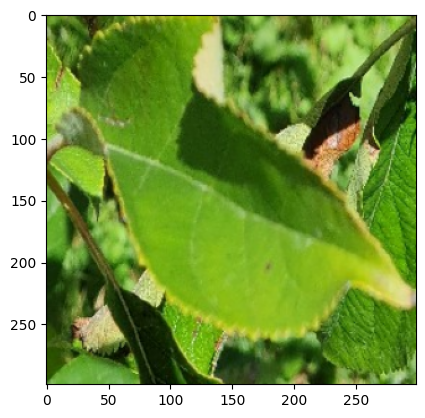

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model_tl.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Plotting the accuracy, loss and the epoch curves

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

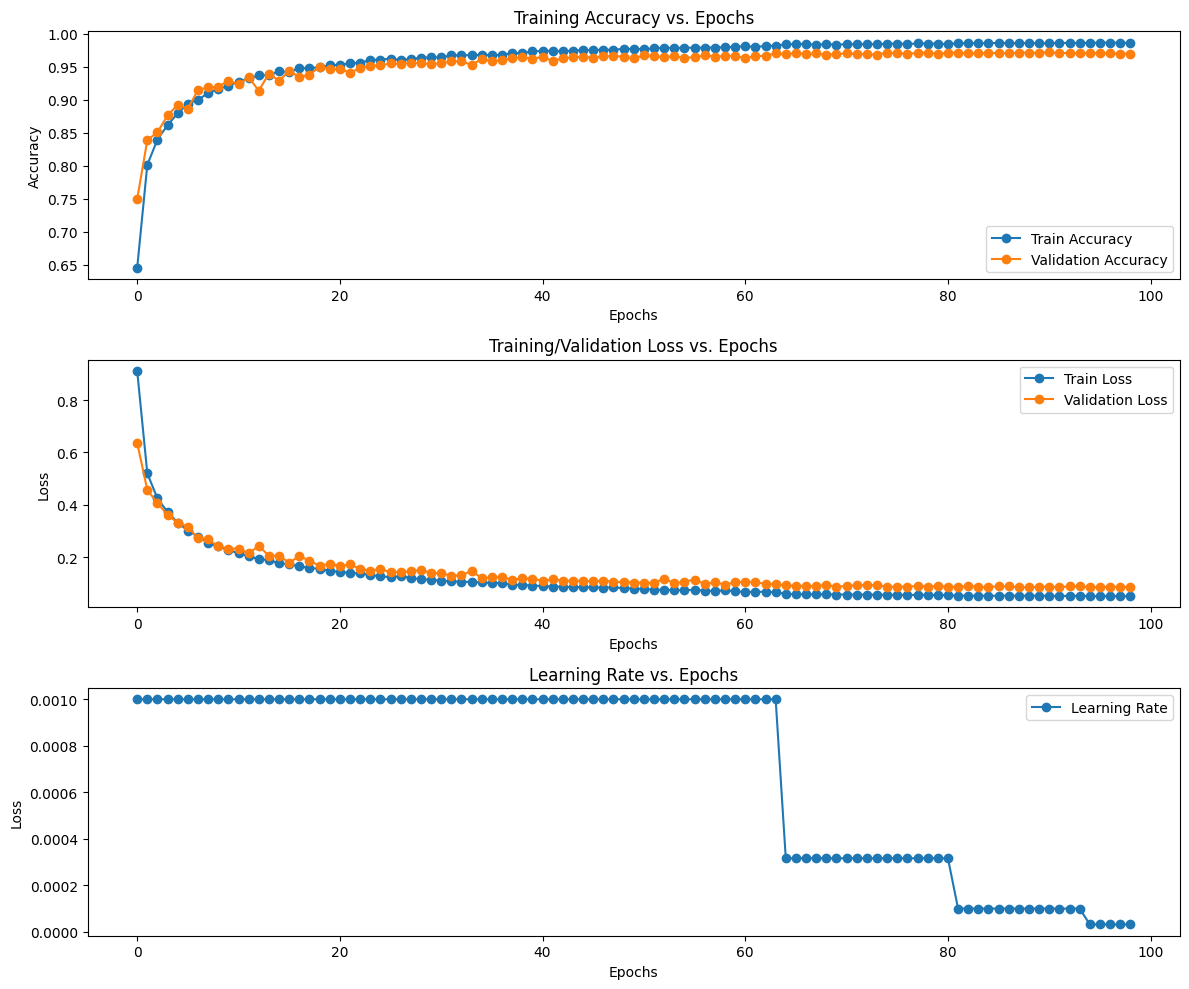

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Confusion matrix

2/2 [==============================] - 0s 47ms/step


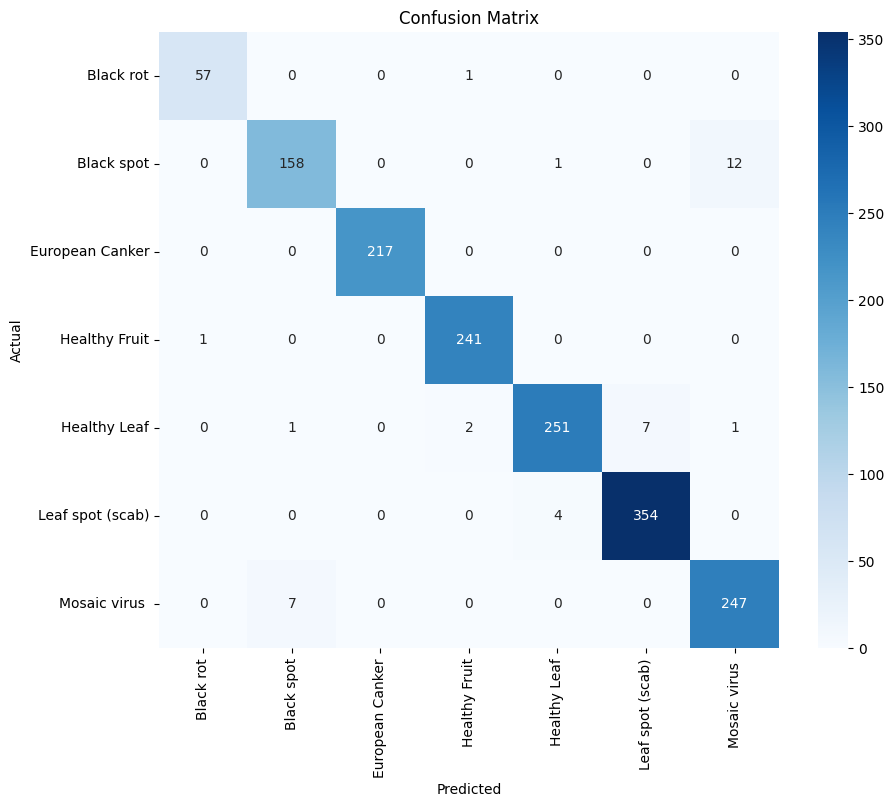

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model_tl.predict(images)  # Get model predictions
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes

# Confusion Matrix with class names
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Classification Report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.98      0.98      0.98        58
      Black spot       0.95      0.92      0.94       171
 European Canker       1.00      1.00      1.00       217
   Healthy Fruit       0.99      1.00      0.99       242
    Healthy Leaf       0.98      0.96      0.97       262
Leaf spot (scab)       0.98      0.99      0.98       358
   Mosaic virus        0.95      0.97      0.96       254

        accuracy                           0.98      1562
       macro avg       0.98      0.97      0.98      1562
    weighted avg       0.98      0.98      0.98      1562



ROC

2/2 [==============================] - 0s 47ms/step


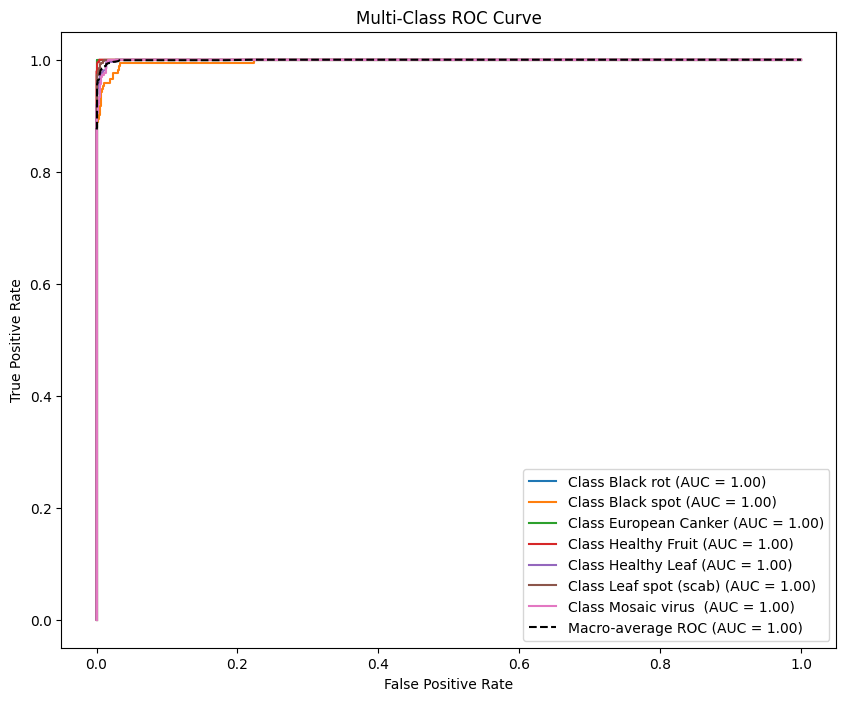

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model_tl.predict(images)  # Get model predictions (probabilities)
    y_pred_probs.extend(predictions)  # Collect predicted probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)  # Ensure true labels are arrays
y_pred_probs = np.array(y_pred_probs)  # Ensure predicted probabilities are arrays

# Binarize the true labels to get a one-hot encoded representation
y_true_bin = label_binarize(y_true, classes=list(range(20)))

# Initialize ROC and AUC data
fpr = dict()  # False positive rates
tpr = dict()  # True positive rates
roc_auc = dict()  # AUC for each class

# Compute ROC and AUC for each class
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # ROC data for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # AUC for each class

# Compute macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)

# Compute mean true positive rates
for i in range(classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= classes  # Normalize by the number of classes
macro_auc = auc(all_fpr, mean_tpr)  # Macro-average AUC

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')  # Label with class names and AUC

# Plot the macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='k', linestyle='--', label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Write a function for inference for the better model - from Scratch

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_tl, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.